# 🧠 Aprendizaje no supervisado
El aprendizaje no supervisado es un tipo de aprendizaje automático (machine learning) en el que un modelo analiza y encuentra patrones en datos que no están etiquetados. Es decir, a diferencia del aprendizaje supervisado, en el aprendizaje no supervisado no se le dice al modelo cuál es la "respuesta correcta"; el modelo debe descubrir por sí mismo la estructura oculta de los datos.

En este trabajo se exploran técnicas de aprendizaje no supervisado utilizando un conjunto de datos de clientes mayoristas. El objetivo es descubrir posibles patrones o agrupamientos ocultos en los datos, mediante el uso de:

- **Análisis de Componentes Principales (PCA)** para reducir la dimensionalidad,
- **K-means** como método de agrupamiento,
- **Selección de características** para simplificar el modelo manteniendo información relevante.

Se trabajará con tres versiones del dataset:
1. El conjunto original.
2. El conjunto reducido a 2 componentes principales por PCA.
3. El conjunto tras eliminar variables redundantes (por alta correlación).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier

## 🧾 1. Exploración y limpieza básica
Se inicia con la carga y exploración básica del dataset. Como paso fundamental antes de aplicar PCA y K-means, se estandarizan todas las variables numéricas para que tengan media 0 y desviación estándar 1.

In [2]:
datos = pd.read_csv("Wholesale customers data.csv")

In [3]:
datos.head

<bound method NDFrame.head of      Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  
0          1338  
1          1776  
2          7844  
3          1788  
4  

In [4]:
datos.describe

<bound method NDFrame.describe of      Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  
0          1338  
1          1776  
2          7844  
3          1788  

El conjunto de datos **Wholesale customers data** contiene información sobre clientes mayoristas de una empresa que distribuye productos alimenticios. El objetivo del dataset es analizar los patrones de compra y potencialmente agrupar a los clientes en distintos perfiles de consumo.

### 🧾 Columnas del dataset:

| Variable     | Descripción                                                              |
|--------------|---------------------------------------------------------------------------|
| `Channel`    | Tipo de canal del cliente: 1 = Horeca (hotel/restaurante/café), 2 = Retail |
| `Region`     | Región geográfica del cliente: 1 = Lisboa, 2 = Oporto, 3 = Otro             |
| `Fresh`      | Gasto anual (en unidades monetarias) en productos frescos                 |
| `Milk`       | Gasto anual en productos lácteos                                          |
| `Grocery`    | Gasto anual en abarrotes                                                  |
| `Frozen`     | Gasto anual en productos congelados                                       |
| `Detergents_Paper` | Gasto anual en detergentes y papel                                 |
| `Delicassen` | Gasto anual en productos delicatessen                                     |

### 🧠 Objetivo del análisis:

El análisis no supervisado busca encontrar **agrupamientos de clientes** similares según sus hábitos de consumo. Esto puede ayudar a:
- Identificar segmentos de mercado.
- Optimizar campañas de marketing.
- Mejorar la logística y distribución de productos.

In [5]:
# Eliminar columnas no necesarias si las hay (si existen columnas no numéricas o ID)
datos.select_dtypes(include=[np.number])

Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669   9656     7561     214              2674   
1          2       3   7057   9810     9568    1762              3293   
2          2       3   6353   8808     7684    2405              3516   
3          1       3  13265   1196     4221    6404               507   
4          2       3  22615   5410     7198    3915              1777   
..       ...     ...    ...    ...      ...     ...               ...   
435        1       3  29703  12051    16027   13135               182   
436        1       3  39228   1431      764    4510                93   
437        2       3  14531  15488    30243     437             14841   
438        1       3  10290   1981     2232    1038               168   
439        1       3   2787   1698     2510      65               477   

     Delicassen  
0          1338  
1          1776  
2          7844  
3          1788  
4          5185  
..          ...  
435        2204  
436        2346  
437        1867  
438        2125  
439          52  

[440 rows x 8 columns]

In [6]:
print("Variables numéricas:", datos.columns.tolist())

Variables numéricas: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


## 📐 2. Estandarización y PCA
Se aplica PCA al conjunto de datos estandarizado con el objetivo de reducir su dimensionalidad y observar cuánta varianza explica cada componente.

In [7]:
# Estandarizar las variables (es necesario para PCA y K-means)
scaler = StandardScaler()
datos_scaled = scaler.fit_transform(datos)

In [8]:
# Aplicar PCA
pca = PCA()
pca_components = pca.fit_transform(datos_scaled)

## 📈 3. Scree plot
Se genera un **scree plot** para visualizar el porcentaje de varianza explicada por cada componente principal. Luego, se seleccionan las **2 primeras componentes**, y se representa gráficamente el resultado en un diagrama de dispersión para observar si se forman agrupamientos naturales.

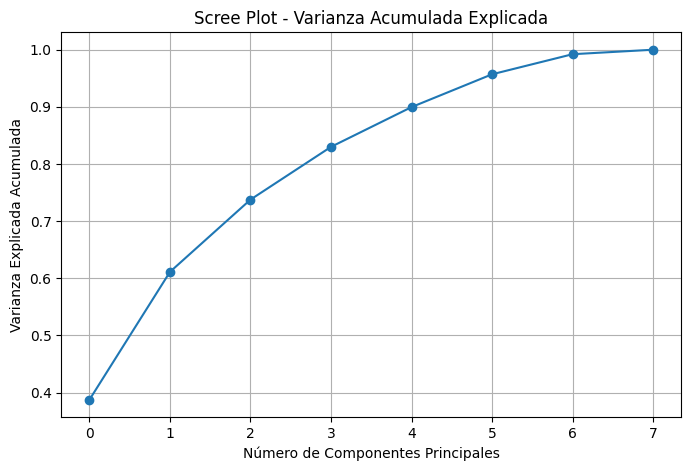

In [9]:
# Graficar el scree plot
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Scree Plot - Varianza Acumulada Explicada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid()
plt.show()

## 📐 4. Reducción a 2 componentes principales

In [10]:
# Reducir a 2 componentes principales
pca_2 = PCA(n_components=2)
datos_pca_2 = pca_2.fit_transform(datos_scaled)

## 📊 5. Diagrama de dispersión

In [11]:
# Asumiendo que 'datos' es tu DataFrame original y contiene la columna 'Channel'
if 'Channel' in datos.columns:
    plt.figure(figsize=(10, 8))
    
    # Separar los puntos por canal
    for channel in datos['Channel'].unique():
        mask = datos['Channel'] == channel
        plt.scatter(datos_pca_2[mask, 0], datos_pca_2[mask, 1], 
                    alpha=0.6, edgecolors='w', s=70, 
                    label=f'Channel {channel}')
    
    plt.title('Diagrama de Dispersión - 2 Componentes Principales por Canal', fontsize=14)
    plt.xlabel('Primera Componente Principal (PC1)', fontsize=12)
    plt.ylabel('Segunda Componente Principal (PC2)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Mostrar varianza explicada
    plt.text(0.95, 0.95, f'Varianza explicada:\nPC1: {pca_2.explained_variance_ratio_[0]:.2f}\nPC2: {pca_2.explained_variance_ratio_[1]:.2f}',
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()

## 💬 6. Selección de variables por correlación
Se utiliza un análisis de correlación para eliminar variables altamente correlacionadas entre sí (por encima de 0.85). El objetivo es reducir la redundancia del conjunto de datos, manteniendo solo las variables que aportan información diferente.

Este proceso ayuda a simplificar modelos y a reducir el ruido, mejorando la interpretabilidad sin perder representatividad.

In [13]:
# 1. Calcular la matriz de correlación absoluta
correlation_matrix = datos.corr().abs()

In [14]:
# 2. Mostrar el mapa de calor (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title("Mapa de Correlación entre Variables")
plt.show()

Se generó un mapa de correlación para analizar la relación entre las variables numéricas. Aquellas con una correlación mayor a 0.85 fueron eliminadas por aportar información redundante. Esta técnica de selección de variables mejora la eficiencia de los algoritmos sin comprometer significativamente la calidad del análisis.

In [15]:
# 3. Eliminar variables altamente correlacionadas (> 0.85)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
variables_a_eliminar = [column for column in upper.columns if any(upper[column] > 0.85)]

In [16]:
# 4. Crear nuevo conjunto de datos sin las variables eliminadas
datos_reducido = datos.drop(columns=variables_a_eliminar)

In [17]:
# 5. Mostrar resultados
print("Variables eliminadas por alta correlación (> 0.85):", variables_a_eliminar)
print("Variables restantes:", datos_reducido.columns.tolist())

Variables eliminadas por alta correlación (> 0.85): ['Detergents_Paper']
Variables restantes: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Delicassen']


## ✍️ 7. Aplicar K-means en tres versiones
Se aplica el algoritmo de agrupamiento K-means a tres versiones del dataset:

1. **Original** (todas las variables estandarizadas).
2. **Reducción por PCA a 2 componentes**.
3. **Conjunto reducido tras eliminación de variables correlacionadas**.

Para cada versión se prueba con valores de `K` entre 2 y 6. Se evalúan los resultados con:

- El **método del codo**, que permite identificar visualmente un buen número de clusters.
- El **silhouette score**, que mide la coherencia interna de los clusters (entre -1 y 1).

In [18]:
def evaluar_kmeans(nombre, data):
    print(f"\n📊 Evaluando K-means en: {nombre}")
    
    inercia = []
    sil_scores = []
    Ks = range(2, 7)
    
    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        etiquetas = kmeans.fit_predict(data)
        inercia.append(kmeans.inertia_)
        score = silhouette_score(data, etiquetas)
        sil_scores.append(score)
        print(f"K = {k} | Silhouette Score = {score:.4f}")
    
    # Gráficos dentro de la función
    plt.figure(figsize=(12, 5))

    # Gráfico del codo
    plt.subplot(1, 2, 1)
    plt.plot(Ks, inercia, marker='o')
    plt.title(f'Método del Codo - {nombre}')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inercia')
    plt.grid(True)

    # Gráfico de silhouette
    plt.subplot(1, 2, 2)
    plt.plot(Ks, sil_scores, marker='s', color='green')
    plt.title(f'Silhouette Score - {nombre}')
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


📊 Evaluando K-means en: Datos Originales
K = 2 | Silhouette Score = 0.5115
K = 3 | Silhouette Score = 0.4630
K = 4 | Silhouette Score = 0.3345
K = 5 | Silhouette Score = 0.3763
K = 6 | Silhouette Score = 0.3695


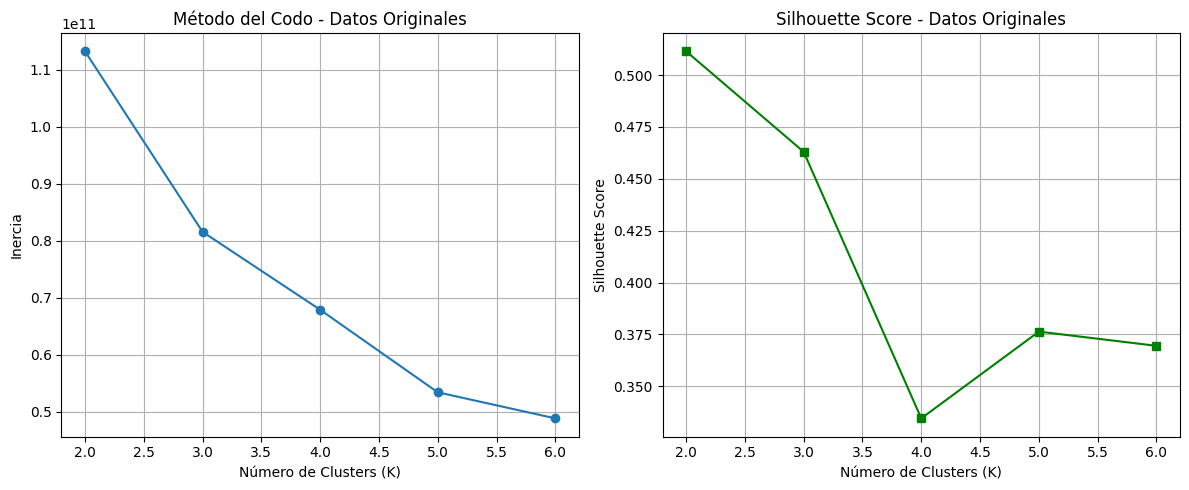

In [19]:
# Dataset original
evaluar_kmeans("Datos Originales", datos)

In [20]:
# Dataset con PCA a 2 componentes
evaluar_kmeans("PCA - 2 Componentes", datos_pca_2)


📊 Evaluando K-means en: PCA - 2 Componentes
K = 2 | Silhouette Score = 0.5453
K = 3 | Silhouette Score = 0.5490
K = 4 | Silhouette Score = 0.5488
K = 5 | Silhouette Score = 0.5320
K = 6 | Silhouette Score = 0.5248


In [21]:
# Dataset reducido tras selección por correlación
evaluar_kmeans("Datos Reducidos por Correlación", datos_reducido)


📊 Evaluando K-means en: Datos Reducidos por Correlación
K = 2 | Silhouette Score = 0.5228
K = 3 | Silhouette Score = 0.4748
K = 4 | Silhouette Score = 0.3513
K = 5 | Silhouette Score = 0.3801
K = 6 | Silhouette Score = 0.3307


## 🧠 Comparación de Resultados: K-means sobre los 3 enfoques

| Dataset                        | Mejor K | Mejor Silhouette Score | Observaciones clave                                                                 |
|-------------------------------|---------|-------------------------|-------------------------------------------------------------------------------------|
| **Original**                  | 2       | 0.5115                  | Agrupamientos aceptables, pero con rápida caída en calidad para K > 2.              |
| **PCA (2 componentes)**       | 3       | **0.5490**              | Mejor definición de grupos. Visualmente más separables. Menor dimensionalidad.      |
| **Reducido por correlación** | 2       | 0.5228                  | Menor dimensionalidad manteniendo variables reales, con buena separación inicial.   |

---

### ✅ **Conclusiones Finales**

- El **mejor desempeño global** se obtuvo con los datos **reducidos mediante PCA**, con un *silhouette score* superior y mejor equilibrio entre complejidad y estructura clara de clusters.
- El conjunto **reducido por correlación** también fue eficaz, con buena calidad en K=2, aunque decayó más rápido que PCA a partir de K=3.
- El conjunto **original** muestra agrupamientos razonables pero más débiles y con mayor riesgo de sobreajuste debido a la dimensionalidad completa.

## 🧾 Conclusiones Finales Específicas al Dataset de Clientes Mayoristas

1. **Segmentación Natural en K=2:**
   - En los tres enfoques (original, PCA, y reducción por correlación), el valor de **K=2** ofreció el mejor o segundo mejor *Silhouette Score*, lo que sugiere que **el conjunto de clientes puede dividirse de forma natural en 2 grandes grupos**.
   - Esto podría reflejar una división entre **clientes con alto consumo general** (por ejemplo, retailers u hoteles) y **clientes con un patrón de compra más limitado o especializado**.

2. **Mejor rendimiento con PCA:**
   - El enfoque basado en **PCA (2 componentes)** logró el *Silhouette Score* más alto (0.5490 con K=3), lo que indica que **la reducción de dimensionalidad permitió descubrir una estructura más clara** en los datos.
   - Esta transformación facilitó la visualización de los clusters y la eliminación de ruido o redundancia entre las variables.

3. **Importancia de las variables correlacionadas:**
   - Al reducir el conjunto original eliminando variables altamente correlacionadas (como *Grocery* y *Detergents_Paper*), se mantuvo una **buena calidad de clustering con menos dimensiones**, lo cual es útil si se desea mantener interpretabilidad usando variables originales.
   - Esto sugiere que algunas variables del dataset **aportan información similar** y pueden ser redundantes para la segmentación.

4. **Aplicabilidad práctica:**
   - Los grupos identificados pueden ser usados para:
     - Diseñar estrategias de marketing diferenciadas por tipo de cliente.
     - Optimizar inventarios o logística según patrones de consumo.
     - Identificar clientes con comportamientos atípicos o especiales.


### 📌 Conclusión General

El análisis muestra que es posible realizar una **segmentación efectiva de clientes mayoristas** usando aprendizaje no supervisado, especialmente al aplicar técnicas de reducción de dimensionalidad como PCA. Esta segmentación puede ser una herramienta poderosa para la **toma de decisiones comerciales y personalización de estrategias**.

